# Multi-dimensional Reward Modeling with Uncertainty

Kincaid MacDonald [](https://orcid.org/0009-0006-4686-7488) (Princeton)  
January 22, 2025

We consider augmenting multidimensional reward models with uncertainty estimates, and find that this modestly improves the performance of (previously) state-of-the-art baseline model (ArmoRM). Along the way, we propose a new framework for preference learning inspired by optimal transport.

# Introduction

Standard Reinforcement Learning from Human Feedback models that diverse and enigmatic morass of norms known as ‘human values’ with a single scalar, produced by a black-box LLM. Not only does this demand a great deal from the black-box model, it also hampers efforts to: 1) *interpret* the model’s enacted preferences, 2) *audit* whether imperatives like ‘Safety first!’ are obeyed in all contexts, and 3) *steer* the model towards desired and away from undesirable human behavior.

Multidimensional reward learning has been proposed as a remedy to these issues. Learn separate dimensions for different facets of human value (honesty, helpfulness, verbosity, factuality) — then combine them with flexible and optionally user-customizable weighting schemes. Multidimensional reward models are both intrinsically interpretable and frequently punch well above their model size class – an instance of a ‘reverse alignment tax’. Here, at least, adding more human-defined structure to the problem of learning human values is beneficial.

Yet a fundamental problem in Multidimensional RLHF is how to appropriately combine multiple dimensions of human value. How can a model perform this compression without either *overemphasizing* some facet of human preference, or compressing so much that it loses the value of modeling multiple reward dimensions?

In this project, we consider whether *uncertainty quantification* can alleviate these challenges. After all, there are situations where the correct value of a reward dimension like ‘safety’ is unknowable without extra context. There are also reward values (e.g. ‘code readability’) that, while useful in some scenarios, simply don’t apply to others. Dimension-wise uncertainty quantification could both equip reward models to better utilize extra context-dependent dimensions and be used to more intelligently compress the multiple reward dimensions into a scalar suitable for RL optimization.

We also propose a new more flexible paradigm for preference learning based on optimal transport theory, which replaces the standard reward model trained with Bradley-Terry loss with the dual form of the Wasserstein distance — and is able to natively combine multiple uncertain reward dimensions without weighted sums.

Our results show that incorporating uncertainty into multidimensional reward learning modestly improves the performance of a once state-of-the-art model, and significantly improves its satefy performance.

# Related Work

Standard Reinforcement Learning from Human Feedback (RLHF) follows @Ouyang2022-Traininglanguagemodelsfollowinstructions in performing preference tuning on LLMs via a two-stage process: first, training a (scalar-valued) reward model on (binary) preference data using a Bradley-Terry objective; second, using a reinforcement learning algorithm like Proximal Policy Optimization to fine-tune the given LLM to maximize the learned reward function. This dual training can be finicky, motivating approaches like DPO \[@Rafailov2024-DirectPreferenceOptimizationYourLanguageb\] to shortcut the first stage by learning an *implicit* reward model through directly training the LLM on preference data. Alas, such implicit reward models can be especially sensitive to any distribution shifts between the training data and real-world applications.

Multi-dimensional reward modeling moves in the opposite direction by making the reward model from Stage 1 even more explicit. The dominant practice is to learn a collection of reward models, trained on datasets annotated to highlight various dimensions (helpfulness, honesty, safety, coherence, reasoning, etc.) of valuable responses – and then ‘compress’ these dimensions into a scalar suitable for Stage 2 optimization with a *fixed* weighted sum \[@Ji2023-BeaverTailsImprovedSafetyAlignmentLLM; @Wu-FineGrainedHumanFeedbackGivesBetter; @Cui2024-UltraFeedbackBoostingLanguageModelsScaled\]. Some allow the sums’ weights to be changed to represent different users’ preferences \[@Wang2024-ArithmeticControlLLMsDiverseUser\]. The most sophisticated approaches use a dynamically-weighted sum based on context, as in @Wang2024-InterpretablePreferencesMultiObjectiveRewardModelinga’s Absolute-Rating Multi-Objective Reward Model (ArmoRM), which we will discuss below.

Alternative approaches include @Ethayarajh2024-KTOModelAlignmentProspectTheoretic, which adapts psychologists Amos Tversky and Daniel Kahneman’s Prospect Theory to LLM alignment; and @Chakraborty2024-MaxMinRLHFAlignmentDiverseHumanPreferences, who eschews the linear combination of rewards to learn directly from a collection of specialized reward models via an expectation maximization objective modeled after the Egalitarian Principle of social choice theory.

Some have also investigated the intersection of uncertainty estimation with reward modeling. @Eisenstein2024-RewardModelEnsemblesMitigatenot found that ensembling (scalar-valued) reward models improved robustness against reward hacking. A competing approach to uncertainty estimation, Epistemic Neural Networks \[@Osband2023-EpistemicNeuralNetworks\], has been found useful in active learning: uncertainty-equipped reward values can prioritize data in a fine-tuning corpus that best increases LLM performance \[@Dwaracherla2024-EfficientExplorationLLMs\].

# ArmoRM

For direct comparability with previous work, we build our uncertainty-aware reward model on top of what may be the most popular multidimensional reward model, @Wang2024-InterpretablePreferencesMultiObjectiveRewardModelinga’s “Absolute-Rating Multi-Objective Reward Model”. ArmoRM was, for a time, the best performing 8b parameter reward model and (at the time of release) performed competitively with 70b parameter models.[1]

Here, we give a brief overview of the ArmoRM architecture. We then present some results on the base ArmoRM model that raise questions about its effectiveness at handling multiple dimensions, which motivate our uncertainty-aware paradigm. We’ll also note that we were unable to replicate ArmoRM’s published scores, even using the authors’ own training code – which, rather troublingly, has a severe bug that overrides one of the main pieces of their published architecture. Full details on this are in the appendix.

First, an overview of the method. Intuitively, ArmoRM performs context-dependent weighting of multiple reward dimensions. It adapts the importance assigned to ‘verbosity’ or ‘honesty’ to the context given by the prompt. In theory, this should allow niche reward dimensions like ‘code readability’ to be upweighted when writing code and ignored otherwise. It should also allow, e.g., ‘helpfulness’ to be prioritized over safety in contexts determined to be benign, and vice versa.

Concretely, this consists of three pieces: an LLM embedding module, a linear regression layer, and an MLP gating layer. First, a given prompt and response are embedded by taking activations from the final layer of the LLM module. Then, the linear regression layer maps the embedded prompt-response pairs to 19 dimensions of reward values. The gating layer then maps the prompt embedding to a set of *gating weights* $w_i$ for each of the 19 reward dimensions. Finally, a weighted linear sum $\sum_{i} w_i r_i$ combines the multiple dimensions into a scalar reward value.

<figure>
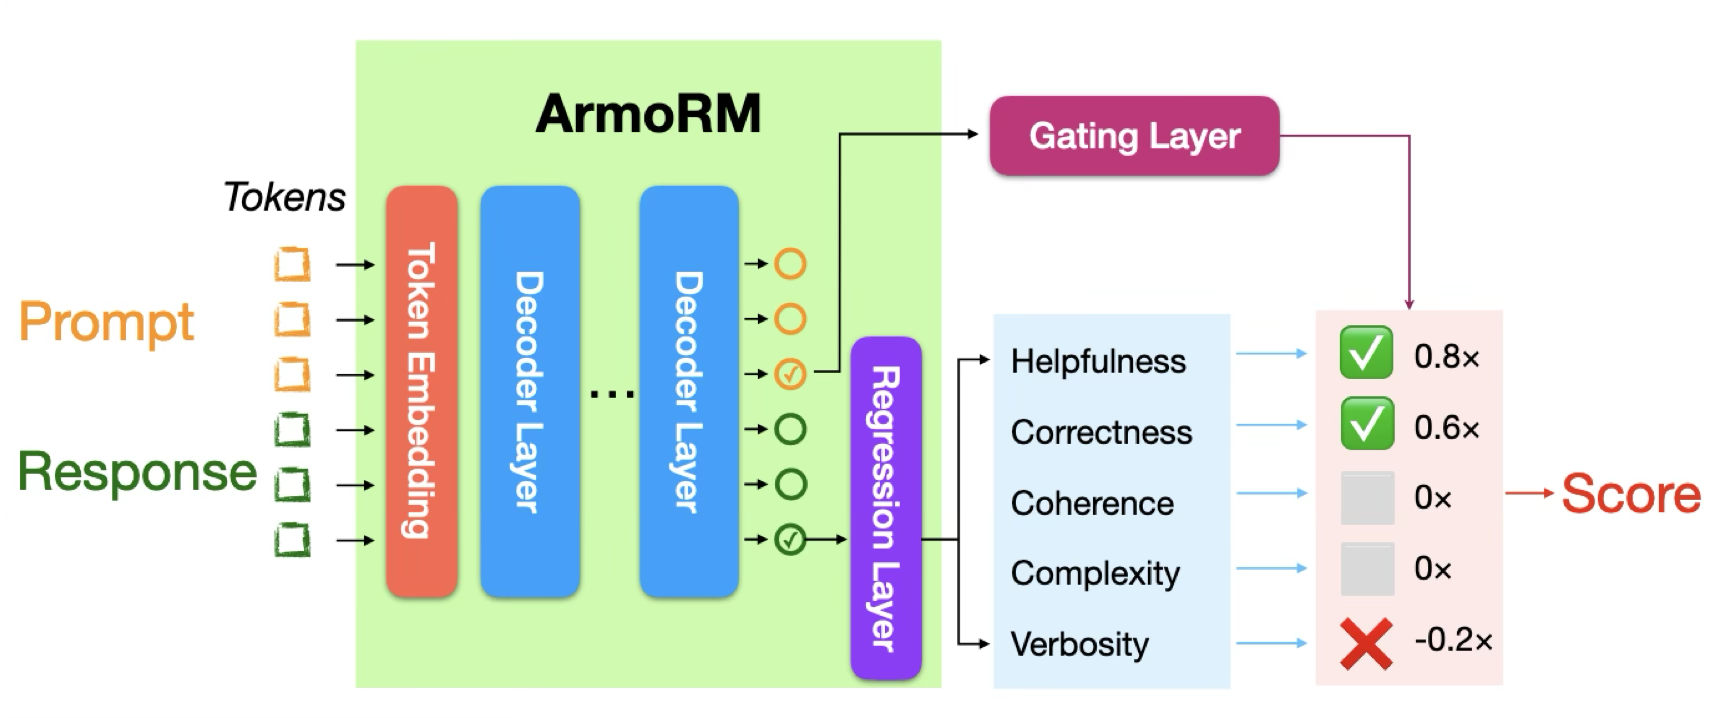
<figcaption aria-hidden="true">ArmoRM’s Model Architecture (from <span class="citation" data-cites="Wang2024-InterpretablePreferencesMultiObjectiveRewardModelinga">[@Wang2024-InterpretablePreferencesMultiObjectiveRewardModelinga]</span>)</figcaption>
</figure>

The regression layer is trained with Ridge regression on a combination of 8 multi-dimensional datasets, each of which has 1-5 dimensions – yielding 19 dimensions in aggregate, with 500k samples. During training, dimensions unused by the current input are masked.

The gating layer is trained with a Bradley-Terry loss on an aggregate of 10 binary preference datasets with over 800K aggregate examples.

The LLM module used for embedding is treated as a ‘frozen stem’ and receives no additional tuning during ArmoRM’s training.

ArmoRM has one final bit of engineering. Noting that reward models can have a bias for undesirably long responses, the authors explicitly correct for this with a *verbosity penalty*. After training the linear regression layer, they subtract the verbosity dimension from the other reward dimensions until each dimension’s correlation with verbosity falls below a hand-tuned threshold.

Unfortunately, in the authors’ public implementation of ArmoRM, this verbosity penalty, once calculated, is never actually used. It’s unclear whether this bug was present in their internal code – even after modifying their code to use the verbosity penalty, we’ve been unable to reproduce their results.

## ArmoRM’s reward dimensions are highly correlated, and only a subset are actually used

ArmoRM learns 19 reward dimensions. Are these encoding usefully different information? And how frequently is each dimension in use?

To investigate, we ran a pre-trained copy of ArmoRM on Frick’s Preference Proxy Evaluations dataset (from Oct. 2024) – a newer, harder reward benchmark which should be unknown to ArmoRM. We visualized each reward dimension over the space of embedded responses, which we’ve plotted in 2 dimensions using the dimensionality-reduction tool PHATE \[@Moon2019-Visualizingstructuretransitionshighdimensionalbiologicala\]. As @fig-armo-reward-variation illustrates, many of ArmoRM’s reward dimensions show striking correlations – all of the code-related dimensions, for instance, show the same pattern of coloration across the space of responses, even when (as with ‘code-complexity’ and ‘code-readability’) their stated values are in direct conflict.

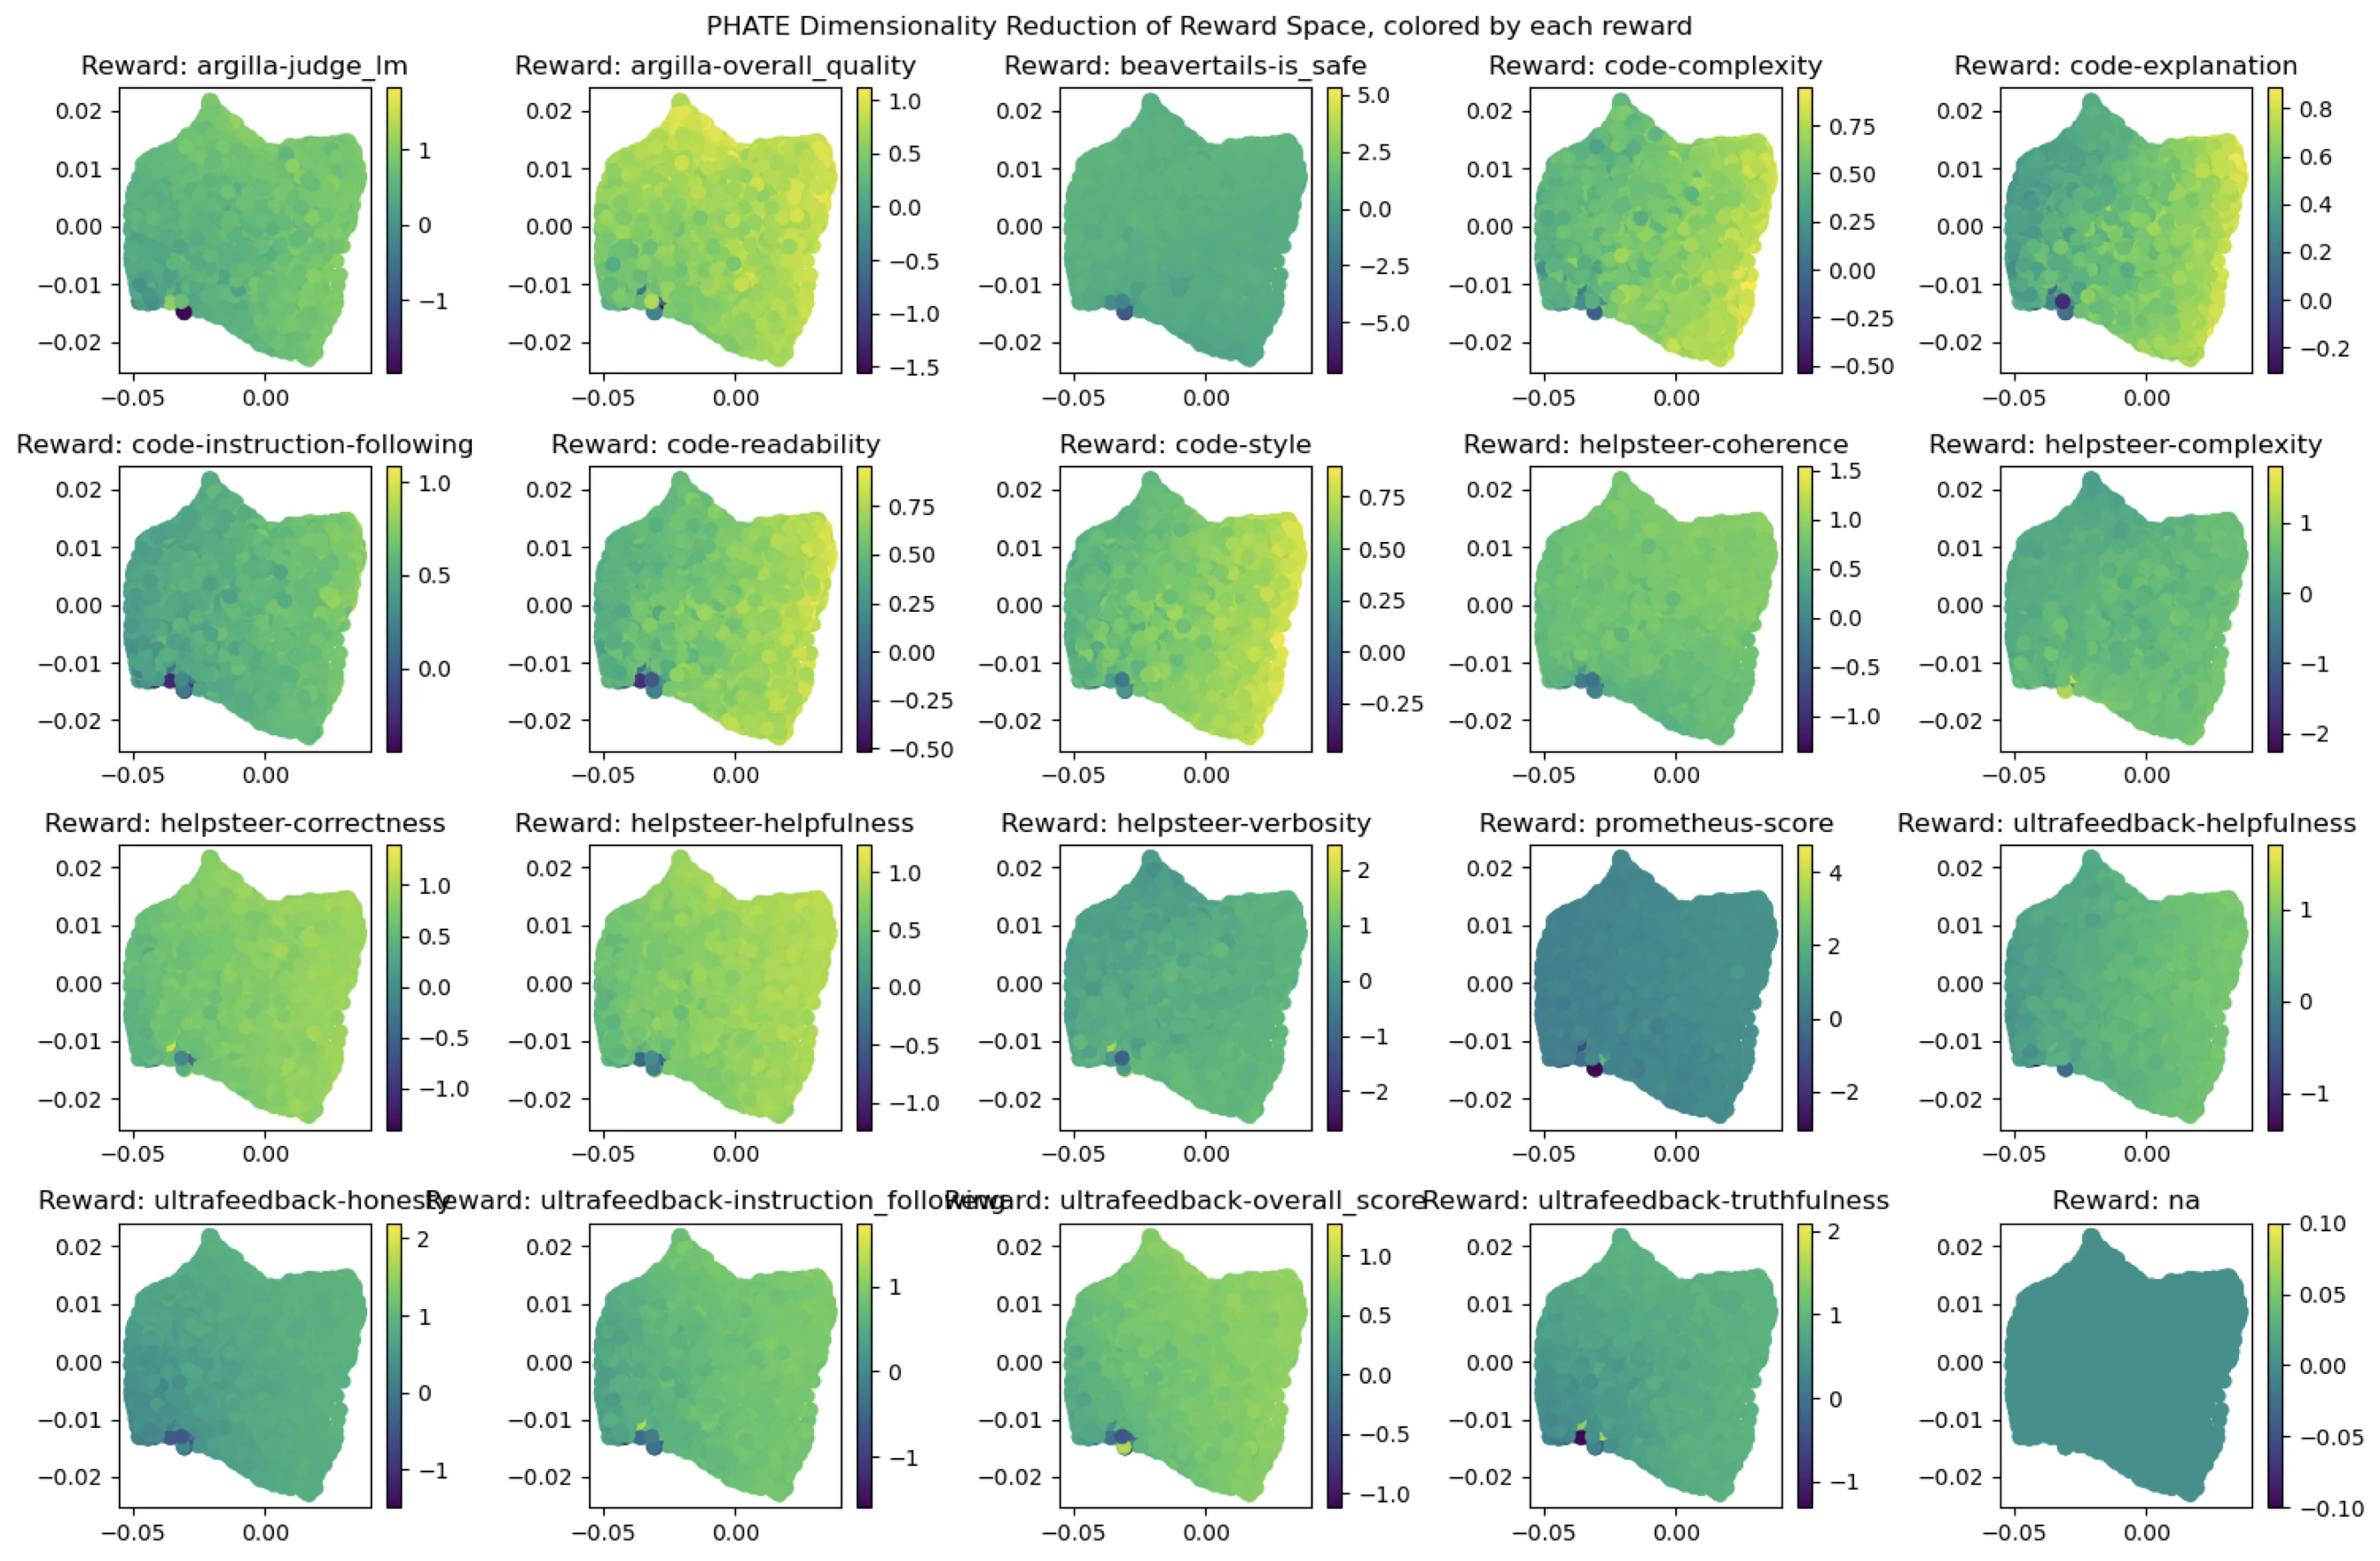{#fig-armo-reward-variation fig-align="center" fig-width="80%"}

The same visualization of the reward gating coefficients $w_i$ reveals that most reward dimensions are ignored entirely by ArmoRM’s gating layer, receiving zero weight over the majority of contexts (@fig-armo-gating-variation). Only five reward dimensions show significant non-zero weighting.

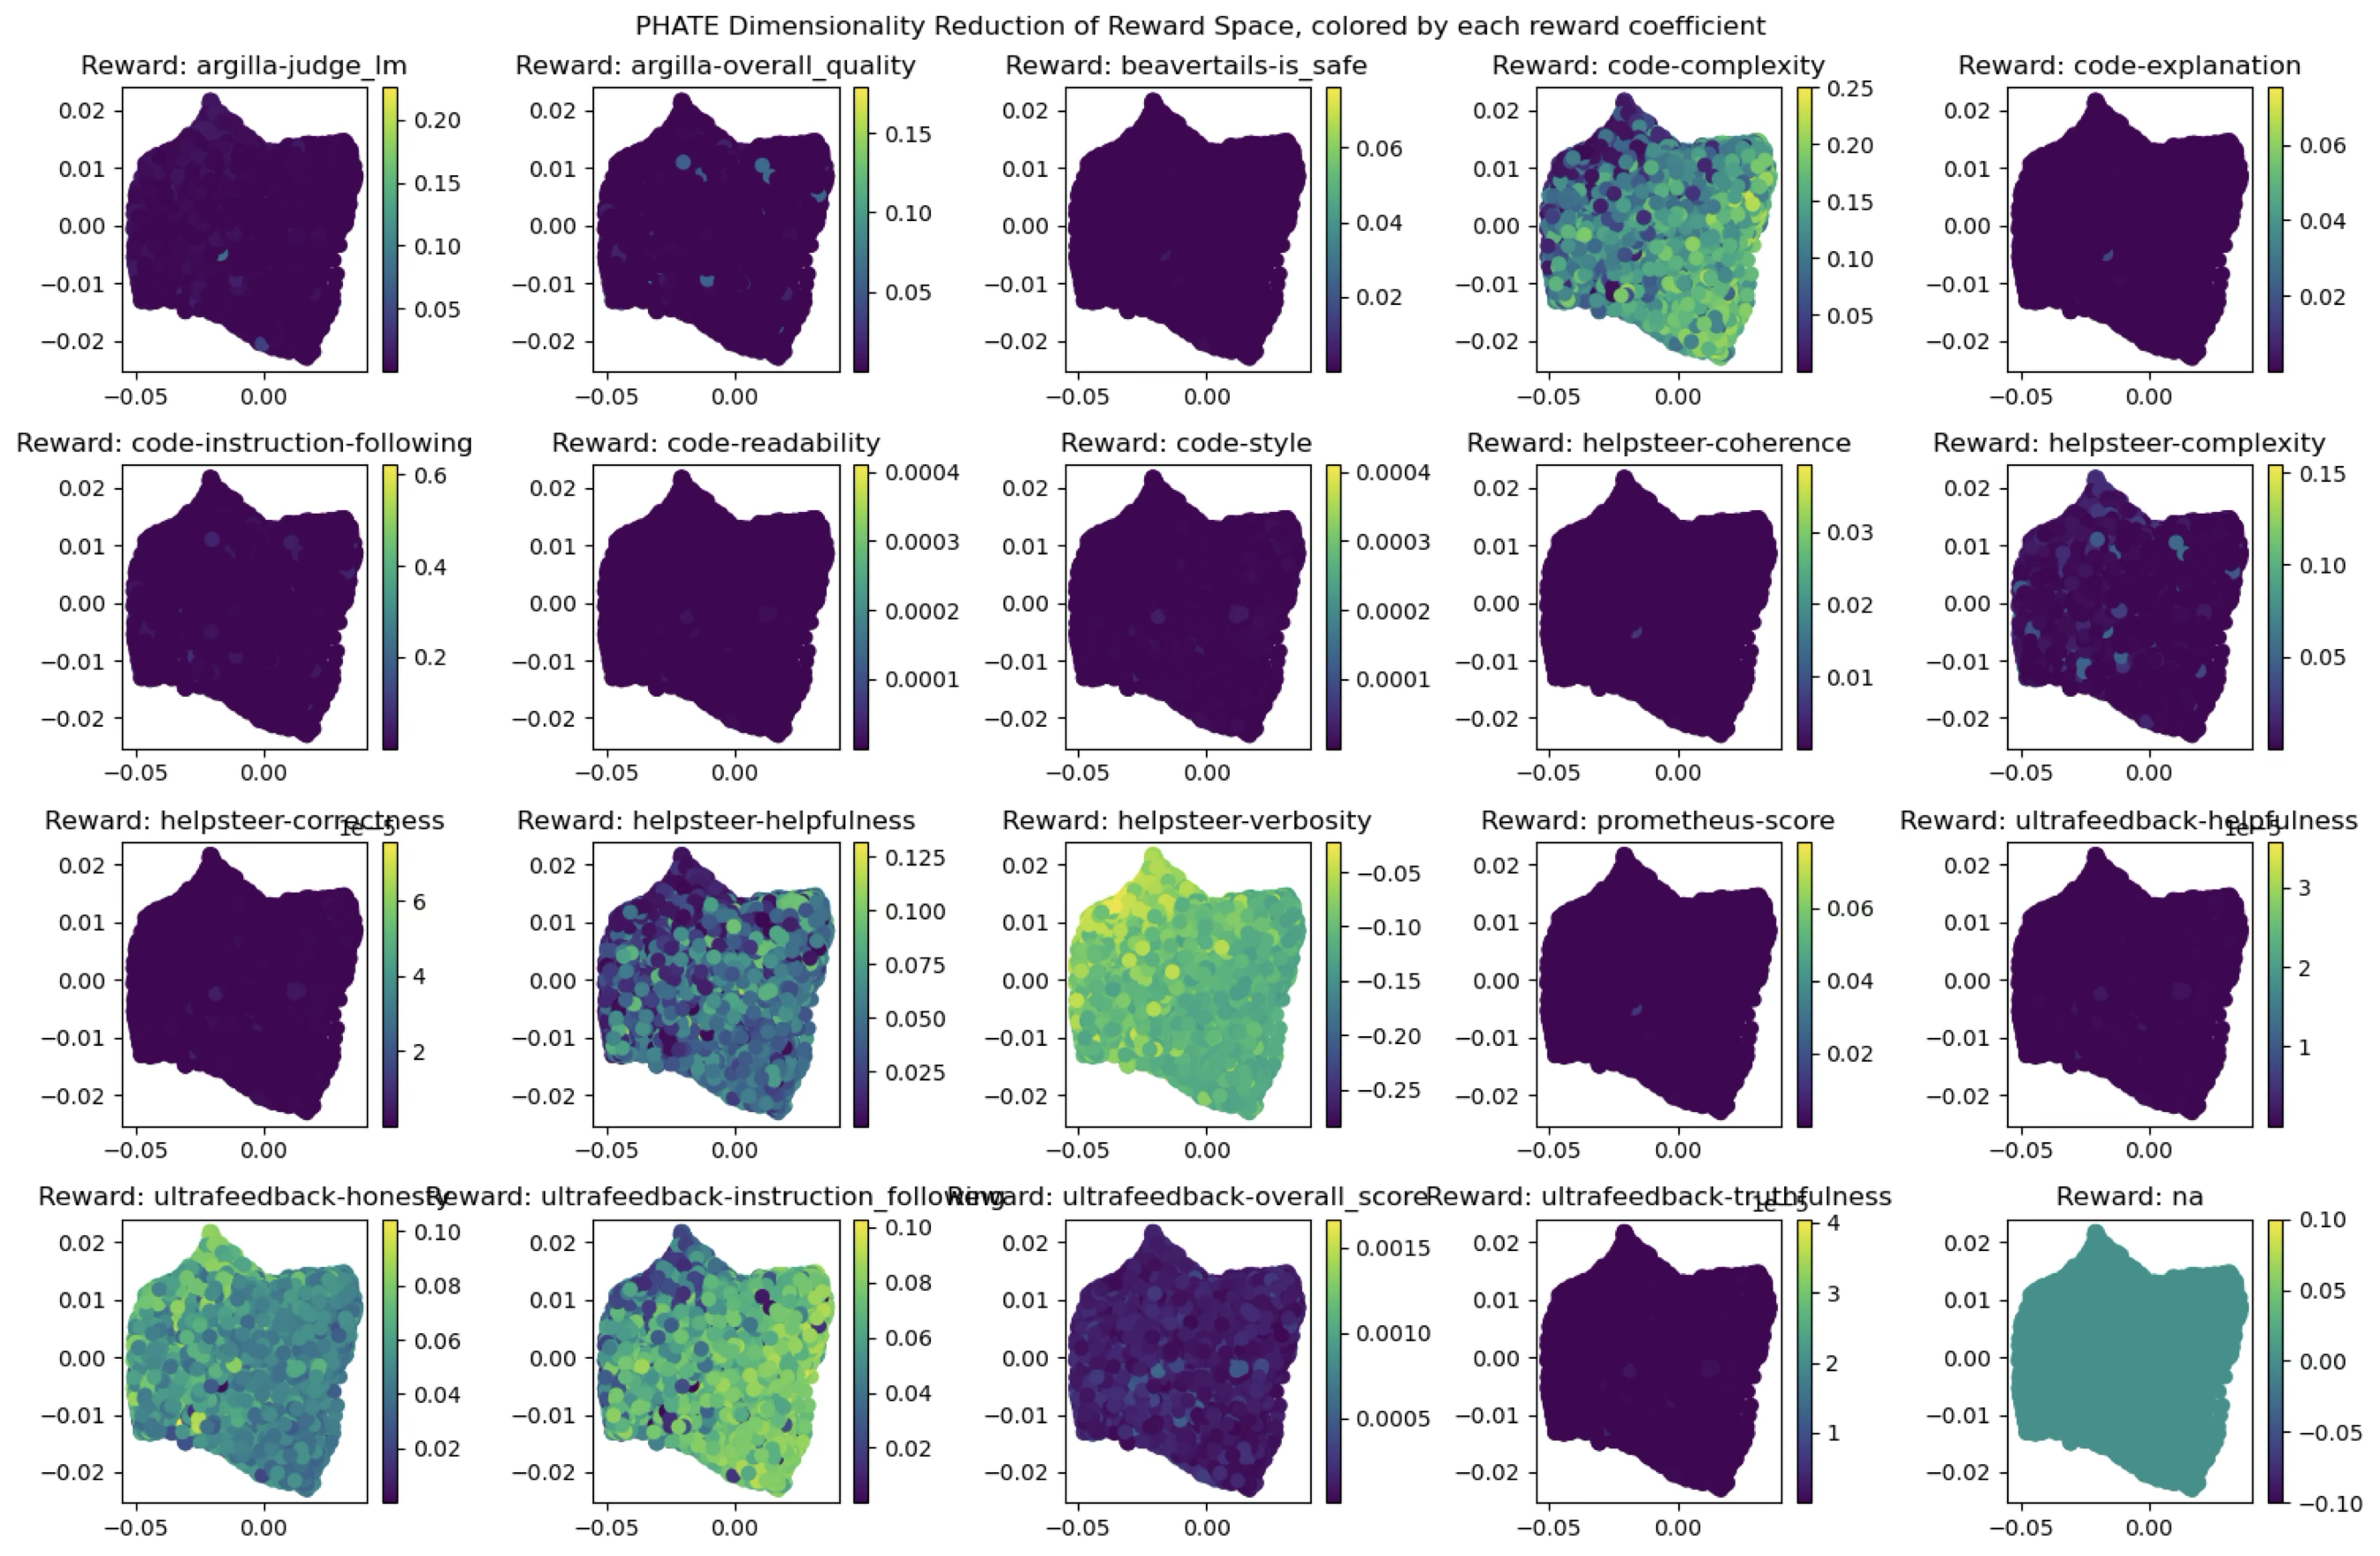{#fig-armo-gating-variation fig-align="center" fig-width="80%"}

These results suggest either that the underlying reward dimensions don’t have much usefully different information, or (more probably) that the combination of ArmoRM’s linear regression layer and the untrained Llama 8b stem underneath isn’t powerful enough to differentiate them. As a result, of the 19 dimensions ArmoRM uses, only 5 appear to be consistently used.

# Wasserstein Reward Modeling: Preference Learning as Optimal Transport

Consider a binary preference dataset, which consists of a set of prompts $P$ and, for each $p_i \in P$, responses $r_1 \in R_1, r_2 \in R_2$, where $R_1$ is the distribution of preferred and $R_2$ the distribution of rejected responses. The task of preference tuning is to guide the distribution of student responses $R_s$ to be ‘close’ to $R_1$ and ‘far’ from $R_2$.

The Bradley-Terry loss treats this as a pairwise classification problem, minimizing a binary cross-entropy loss between the student’s probability of generating from $R_1$ and its probability of generating from $R_2$.

But we can also formulate preference tuning as an optimal transport problem, with a loss given by a distributional distance between $R_s$ and $R_1$. One of the strongest such distances is the Wasserstein distance, defined as

$$W_1(\mu, \nu)=\frac{1}{K} \sup _{\|f\|_L \leq K} \mathbb{E}_{x \sim \mu}[f(x)]-\mathbb{E}_{y \sim \nu}[f(y)]$$

Intuitively, the Wasserstein distance (also called the ‘Earth Mover’s Distance’) measures the minimum energy required to transport all of the ‘mass’ from the first distribution to the second by searching over all possible “transport plans” between the distributions. Equivalently, via the Kantorovich-Rubinstein duality, it can be written as a search over the space of Lipschitz-constrained scalar functions \[@Arjovsky2017-WassersteinGenerativeAdversarialNetworks\]:

$$W_1(\mu, \nu)=\frac{1}{K} \sup _{\|f\|_L \leq K} \mathbb{E}_{x \sim \mu}[f(x)]-\mathbb{E}_{y \sim \nu}[f(y)]$$

A function maximizing this (called a “witness function”) adopts maximally distinct values between the first distribution and the second, thus ‘bearing witness’ to their differences.

This suggests a computationally tractable way to approximate $W_1(R_s, R_1)$. We can view each $R$ as a manifold in the space $\mathbb{R}^{N \times M}$, where each $r$ combines an LLM embedding of the prompt with some representation of the response (e.g. another LLM embedding, or equivalent featurization). First, we compute $W_1(R_1, R_2)$ by training a witness function $w:\mathbb{R}^{2N} \to \mathbb{R}$ to maximally distinguish between these ‘training’ distributions. We can then apply this witness function to the student distribution, obtaining an upper bound: $W_1(R_s, R_1) \leq w(R_1) - w(R_s)$.

Note that this $w$ plays the same role as a reward model. It’s a scalar-valued function over the space of prompts and responses for which higher values for a given prompt predict the preferred response. Furthermore, minimizing $w(R_s)$ (e.g. via PPO) achieves the preference-tuning objective.

Thus far we have shown that a Bradley-Terry-like model of preferences can be recovered from an optimal-transport framing of preference learning. However, the dual-Wasserstein definition of the reward model has extra flexibility that makes it attractive for multidimensional reward learning.

1.  The witness function’s ‘prompt-response’ input space can combine LLM embeddings with arbitrary additional features. Thus, if one has reward dimensions describing verbosity, helpfulness, truthfulness (etc.), these can be incorporated as extra dimensions supplied to the witness function. In this way, Wasserstein reward modeling provides a natural framework for ‘compressing’ multiple reward dimensions into a form suitable for RL optimization.
2.  Unlike Bradley-Terry reward modeling, Wasserstein reward modeling works even without pairwise mappings between the preferred and rejected response distributions. For example, one could train with a dataset of curated *exceptional* responses as $R_1$ and a corpus of average responses as $R_2$.
3.  This also allows for multiple reward samples per prompt-response input. For instance, if using multiple uncertain reward dimensions as additional input features, uncertainty can be represented by a distribution over the reward dimensions – and we can directly train with this distribution.

We’ll later describe a specific adaptation of Wasserstein reward modeling to the regime of multiple uncertain reward dimensions. But we note that the utility of this framing isn’t limited to our setting and might also prove advantageous in more general settings, like combining multiple preference datasets without catastrophic forgetting; or providing the optimization guarantees of a stronger distributional distance (especially if the witness function was periodically re-trained on the current student distribution).

Wasserstein reward modeling also addresses the “Multidimensional Collapse” problem from the introduction: if we learn multiple reward dimensions only to compress them into a scalar suitable for RL optimization, how much information are we losing? In the Wasserstein case, potentially none at all. Optimizing $R_s$ to minimize $w(R_s)$ will (if successful) *recreate* the input distribution of multi-dimensional reward features associated with each prompt. In this way, the reward from $w$ is viewed not as a single-dimensional descriptor of “human values”, but a *distance* between the student’s representation of human values and the teacher’s representation.

# Methods

## Uncertainty Quantification

To quantify the uncertainty of each reward dimension, we use an ensemble of 100 regression layers trained from different random initializations. We can then estimate uncertainty from the ensemble’s distribution of outputs – either by taking the variance per dimension or using the distribution of values directly. Of those approaches we tried for estimating uncertainty, only an ensemble of multi-layer perceptrons passed the sanity check of reporting higher uncertainties on out-of-distribution data. An ensemble of linear networks (following ArmoRM’s regression layer) and an epistemic neural network \[@Osband2023-EpistemicNeuralNetworks\] both reported mostly uniform uncertainties across datasets (see @fig-ensemble-uncertainties).

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div width="50.0%" data-layout-align="left">
<figure>
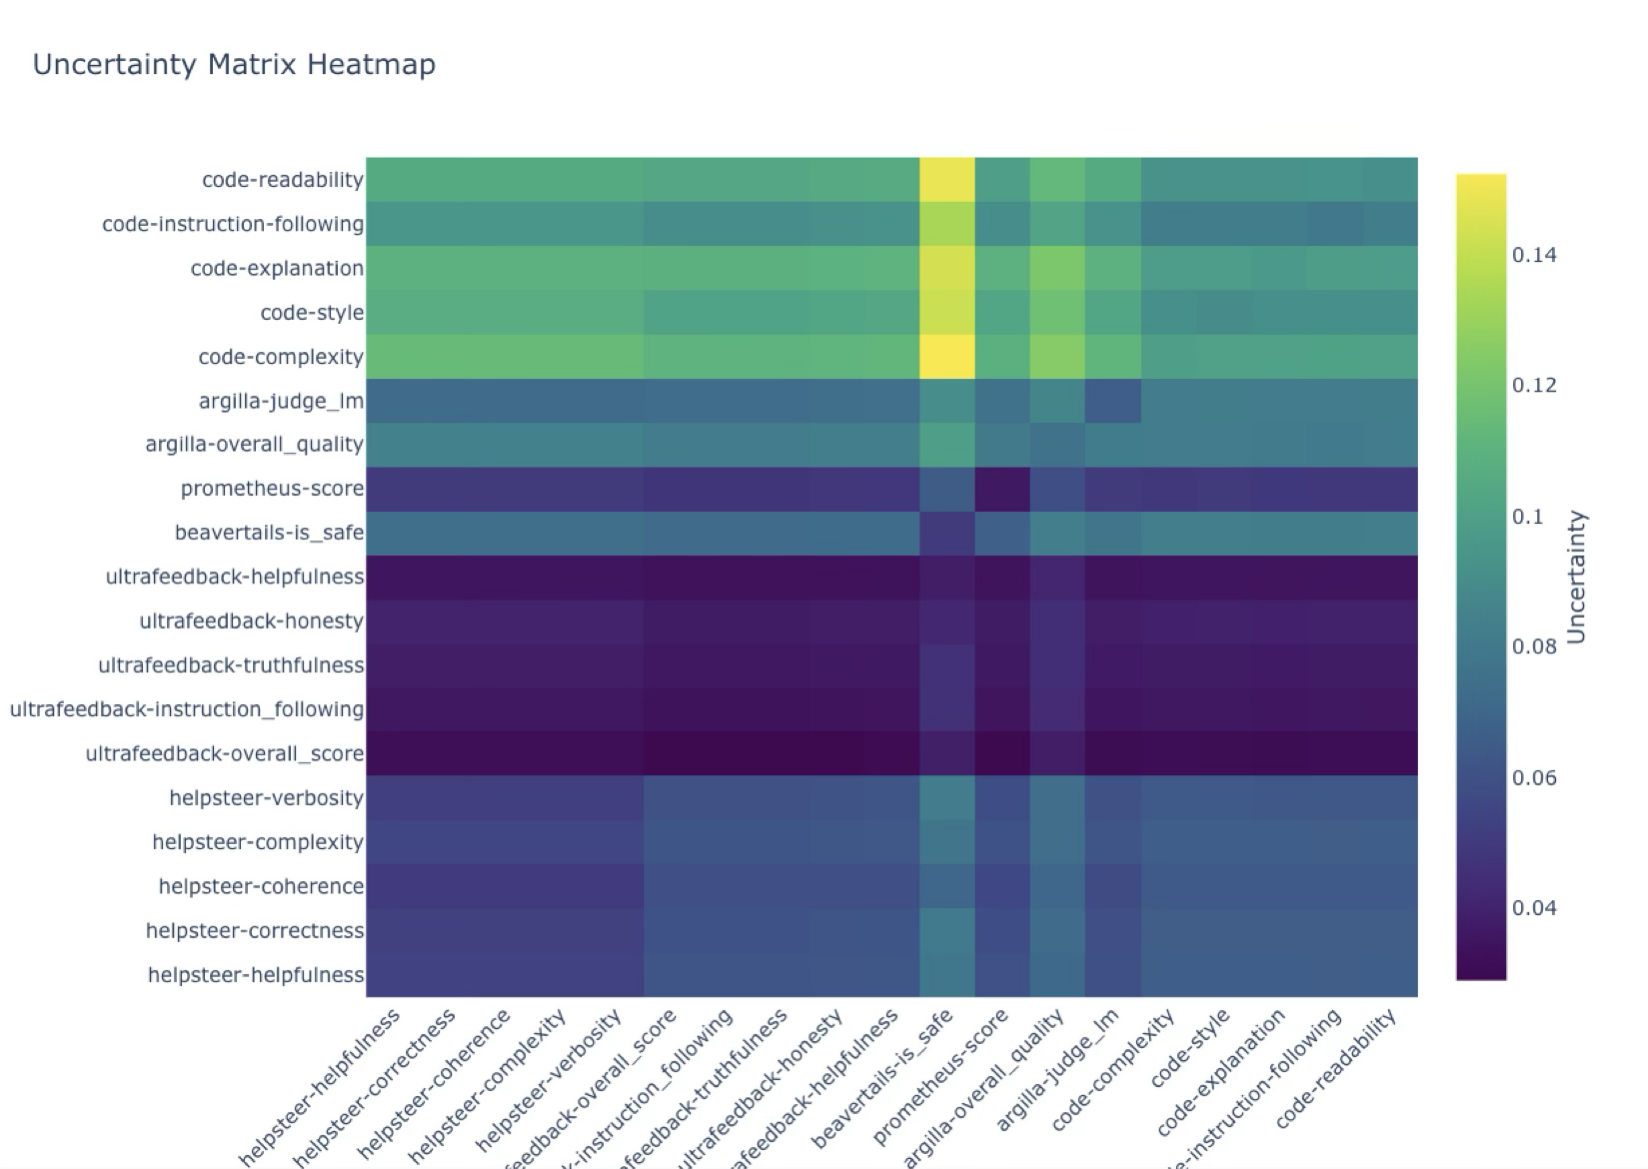
<figcaption aria-hidden="true">Linear Ensemble</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div width="50.0%" data-layout-align="left">
<figure>
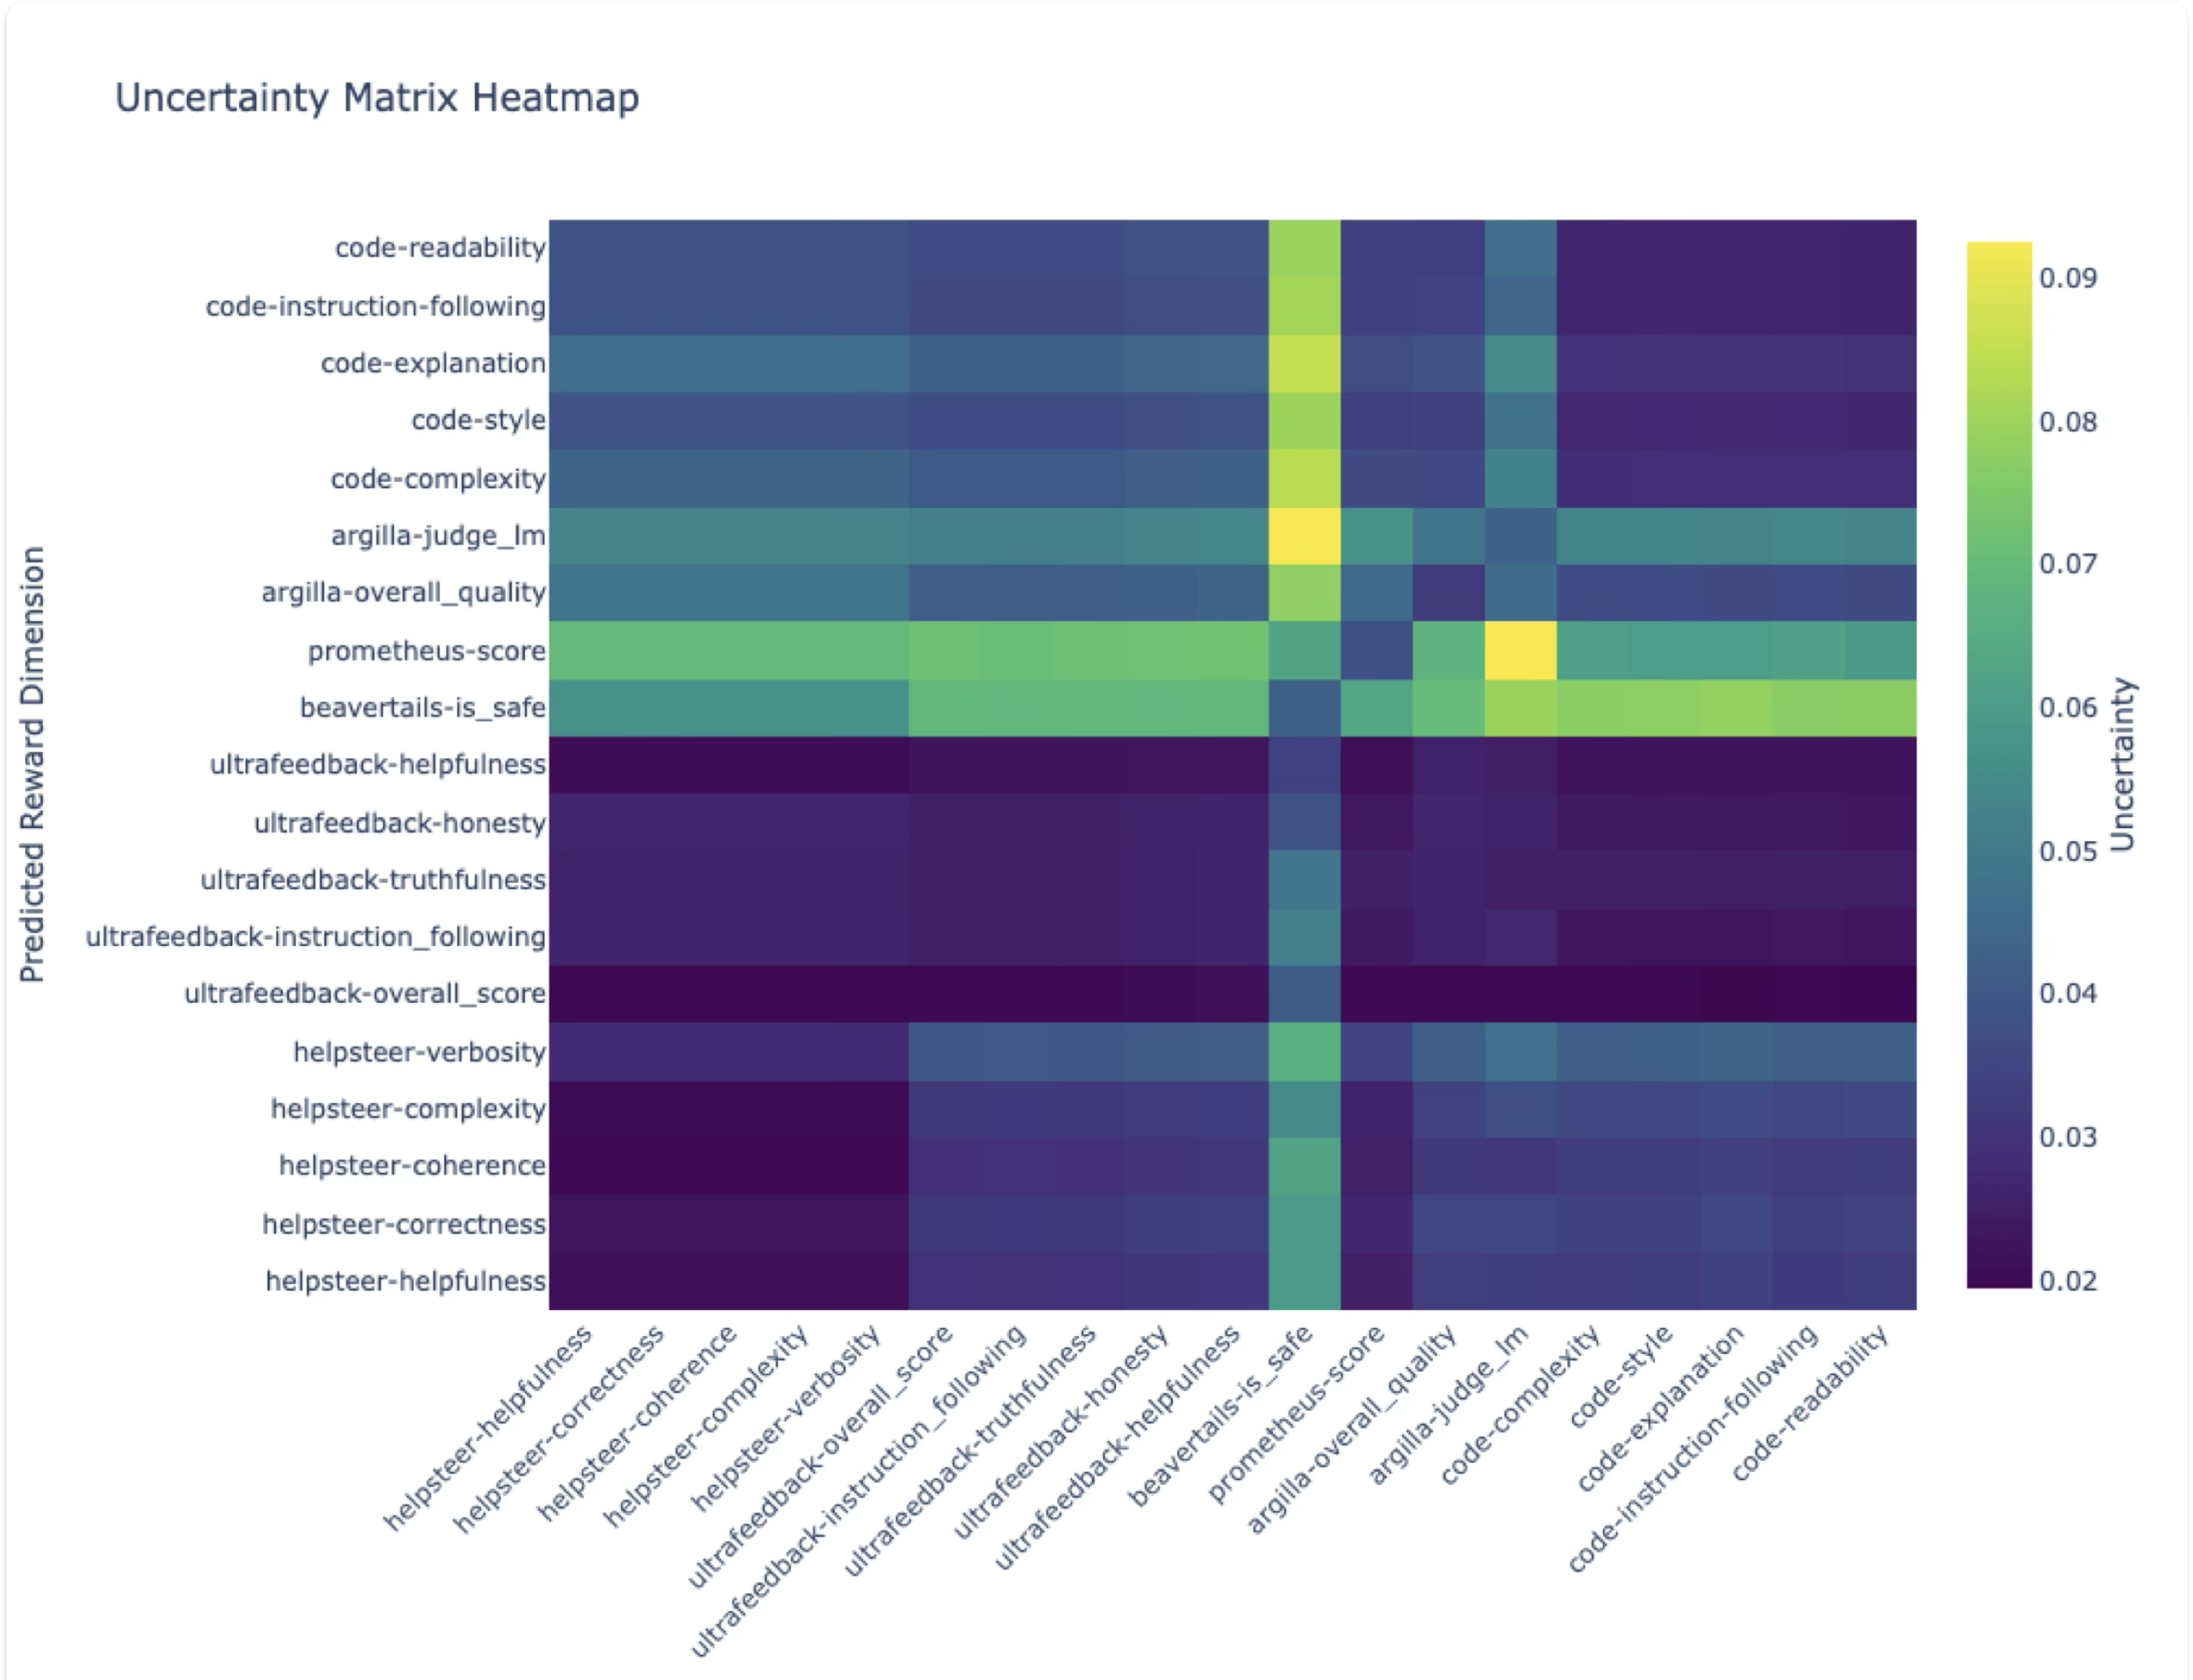
<figcaption aria-hidden="true">MLP Ensemble</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

The uncertainties per reward dimension from this MLP Ensemble (Figure @fig-uncertainties-per-dimension) show that the variance across the ensemble’s samples for a given response was, for most dimensions, a significant portion of the variance across all responses.

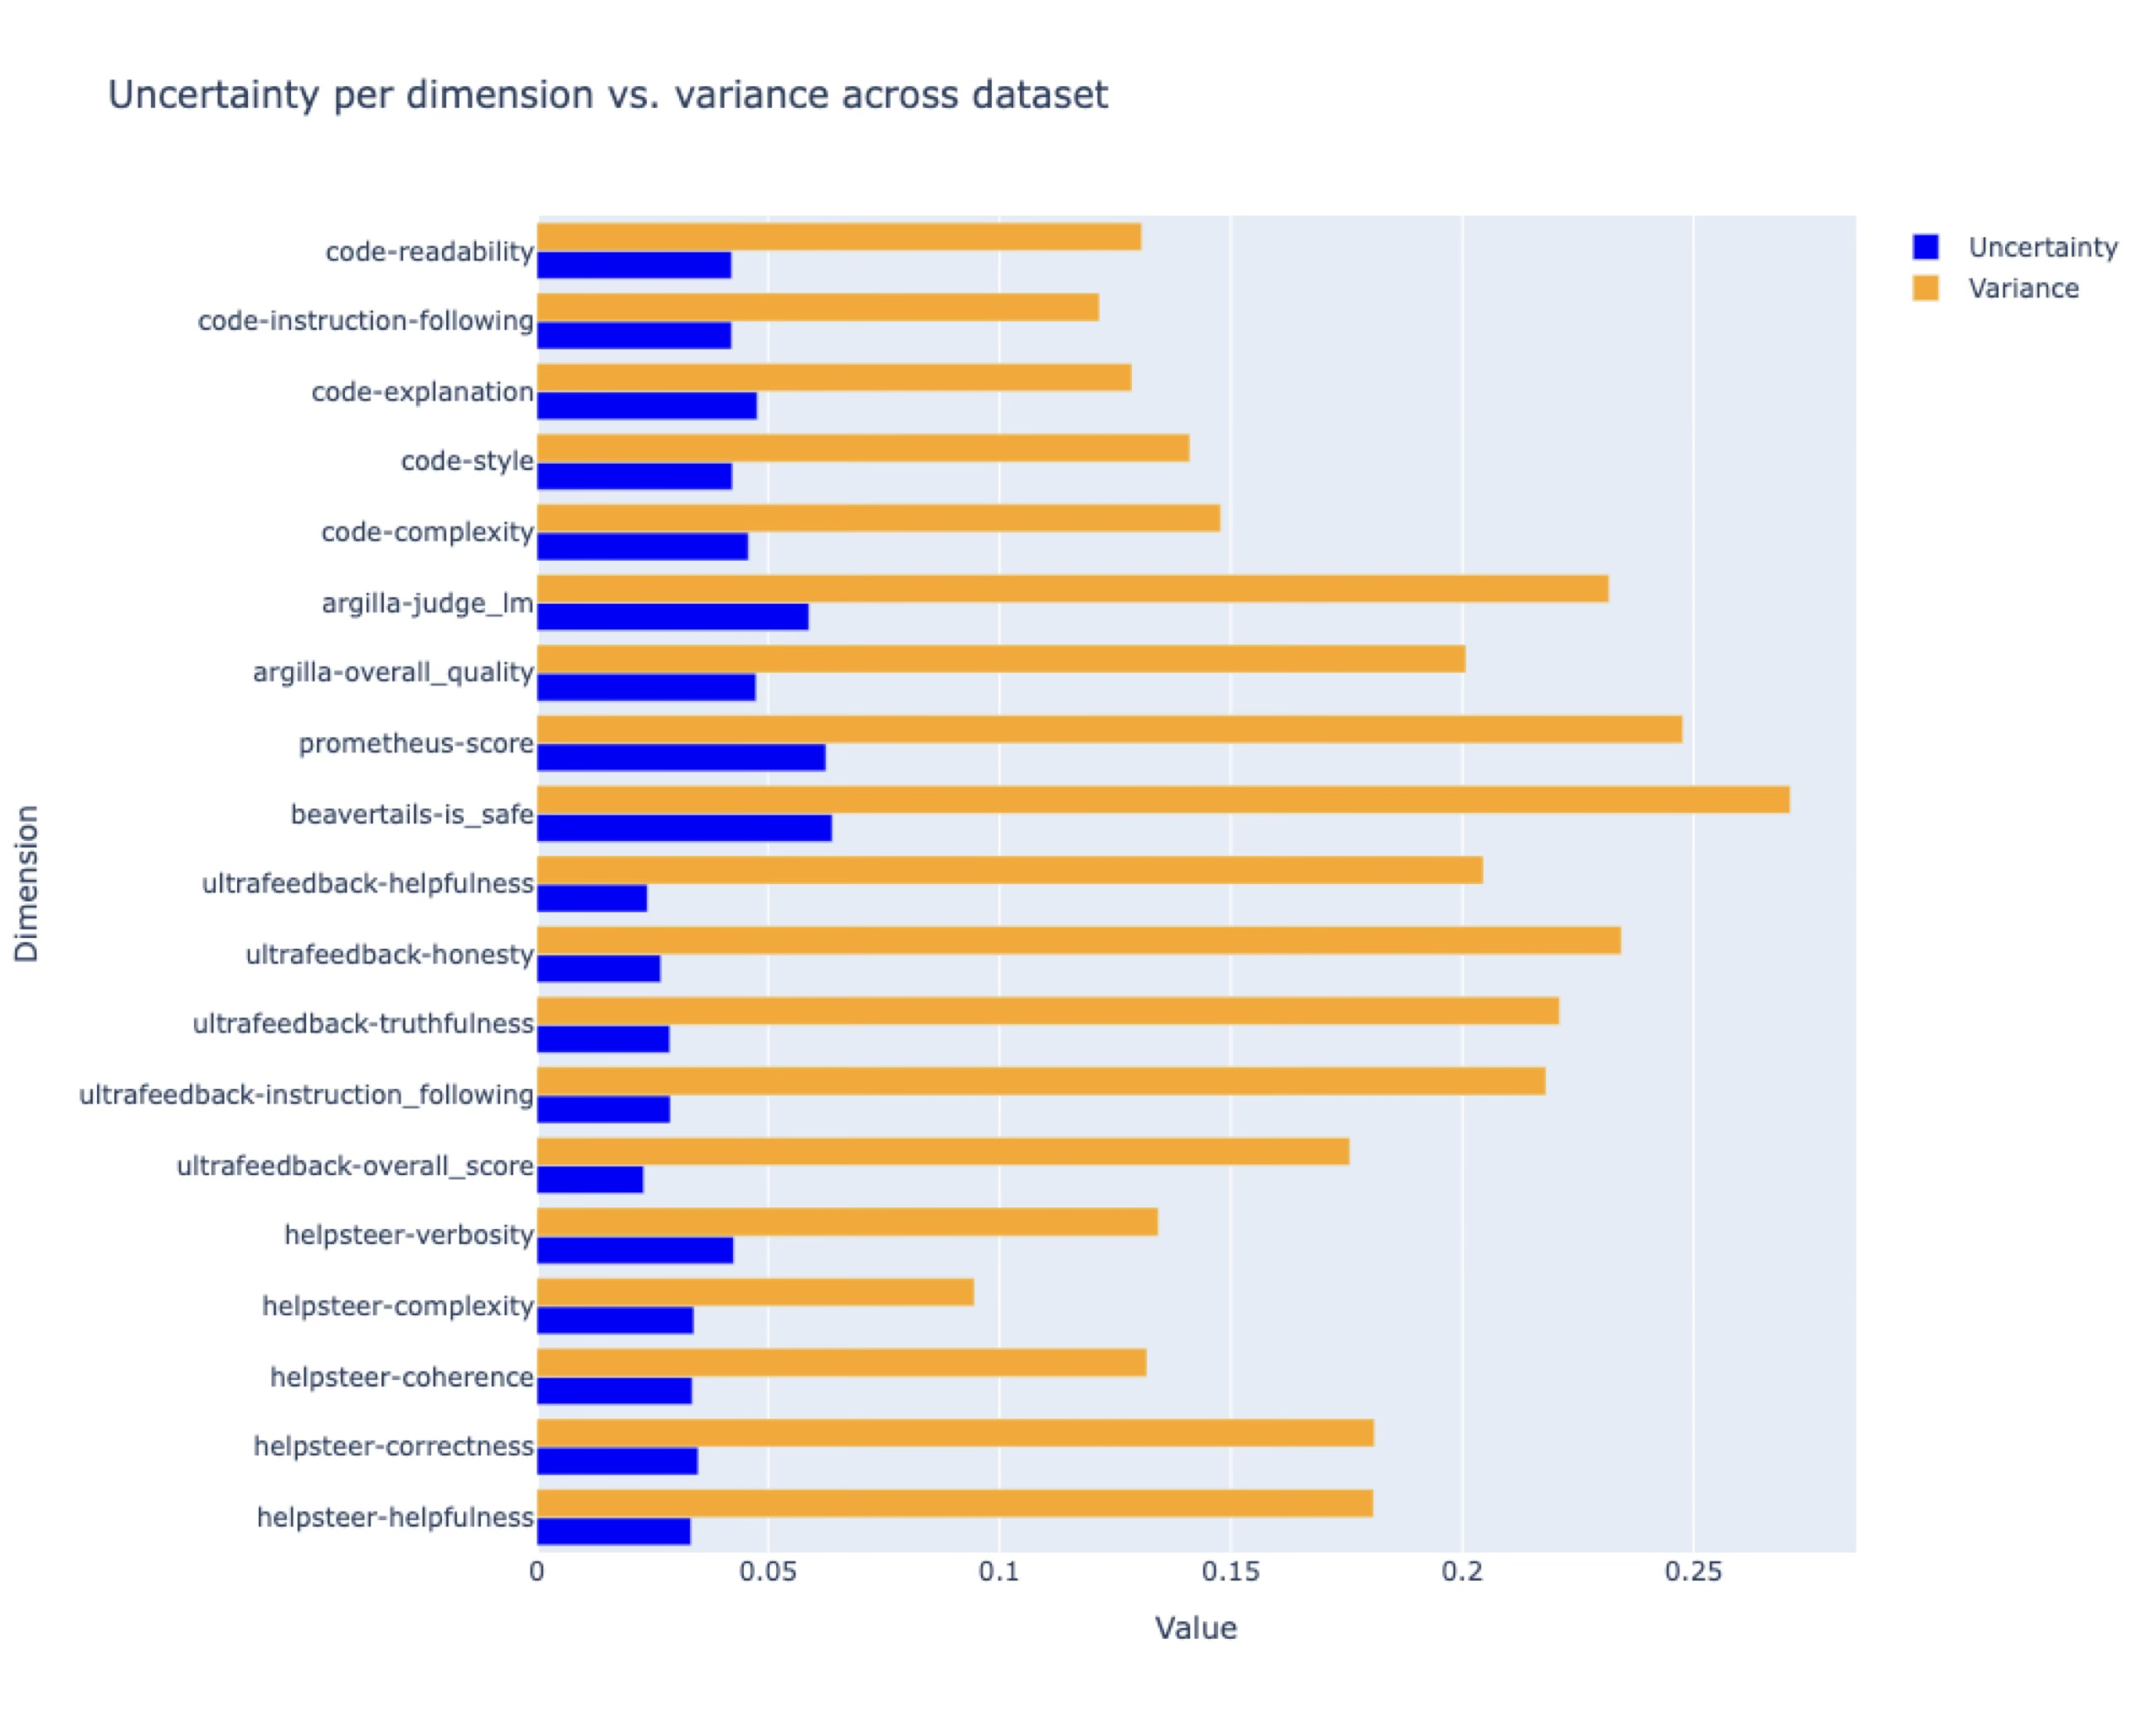{#fig-uncertainties-per-dimension }

## Reward Compression

To use these uncertainties to improve reward compression, we compare three approaches against ArmoRM’s baseline. Let $x,o$ be the LLM embeddings of the prompt and response, respectively; let $r(\vec{o}) = \vec{r}$ be ArmoRM’s multidimensional reward regression layer, and $r_u(\vec{o}) = \vec{r}, \vec{u}$ denote the ensembled MLP version of this layer. Let $g(\vec{x}) = \vec{u}$ be ArmoRM’s gating layer.

Each model described below is trained from scratch on the aggregate binary preference dataset collected by the authors. We use a learning rate of $10^{-5}$, a batch size of 1024, and train for 10000 steps.

**Naive Uncertainty.** Intuitively, the weights assigned to each reward dimension should be lower for reward dimensions with high uncertainty. We implement this directly into the baseline ArmoRM architecture by modifying the output of the gating layer with

$$ w_i' = \text{softmax}(w_i - \alpha u_i) $$

where $w_i$ is the weight assigned to dimension $i$ by the gating layer, and $u_i$ is the variance in dimension $i$ of samples from the MLP Reward Ensemble. The loss and training proceed identically to ArmoRM.

**Bitter Uncertainty.** Here, we feed the uncertainties $u_i$ as extra inputs to the gating layer, taking $w_i = g(x, u)$. The rest proceeds identically to ArmoRM.

For this and the previous method, as well as the baseline ArmoRM, we used the training hyperparameters reported by @Wang2024-InterpretablePreferencesMultiObjectiveRewardModelinga.

**Wasserstein Uncertainty.** We adapt the framework of Wasserstein Reward Modeling to the setting of multiple uncertain dimensions. The input space for the witness function is a concatenation of the prompt embedding $x$ and the reward dimensions $\vec{r}$. To further reduce the dimension of the prompt embedding, we use an additional feature extractor $f: \mathbb{R}^{4096} \to \mathbb{R}^{8}$ which is trained alongside the witness function $w:\mathbb{R}^{8+19} \to \mathbb{R}$. We train with batches of prompt-response pairs with embeddings $x_1, o_1$ and $x_2, o_2$, and use the dual-Wasserstein loss:

$$
l(b_1, b_2) = \sum_i^B \sum_j^E w([f(o_{1i}),r_j(x_{1i})])  - \sum_i^B \sum_j^E w([f(o_{2i}),r_j(x_{2i})])
$$

where $r_j$ denotes the $j$-th MLP of the ensemble of $E$ MLPs, and $B$ denotes the batch size. We find that small batches (~128) improve training stability.

# Results

We evaluated these three models and the baseline ArmoRM implementation on AllenAI’s *RewardBench* \[@Lambert2024-RewardBenchEvaluatingRewardModelsLanguage\]. Note that we were unable to reproduce @Wang2024-InterpretablePreferencesMultiObjectiveRewardModelinga’s published scores for ArmoRM; we below report the scores we obtained training each model from scratch. For context, we include the RewardBench scores of two other top performing models.

@tbl-no-verbosity shows our results. They suggest that *any* form of incorporated uncertainty produces a significant increase in RewardBench’s safety dimension (+10%), resulting in a modest increase in overall score. Reasoning and Chat performance were mostly unaffected, and performance decreased by 3-6% on Chat Hard.

Interestingly, even though Wasserstein Uncertainty Modeling and the Naive (and Bitter) Uncertainty approaches use completely different frameworks, they achieve comparable performance. This may indicate that the Wasserstein approach of considering multiple samples at the same time was neither significantly worse nor better than the summary approach of taking the variance. On the other hand, that the Wasserstein framework achieved similar performance to adaptations of refined, hand-tuned approaches like ArmoRM may indicate its utility.

| No Verbosity | Overall Score | Chat | Chat Hard | Safety | Reasoning |
|------------------------|------------|---------|---------|---------|---------|
| ArmoRM | 82.51 | 98.60 | **69.74** | 78.94 | 82.78 |
| Naive Uncertainty | 84.02 | **99.16** | 63.38 | 89.01 | **84.54** |
| Bitter Uncertainty | **84.15** | 98.60 | 66.67 | **89.76** | 81.57 |
| Wasserstein Uncertainty | 83.83 | 96.93 | 66.89 | 87.99 | 83.54 |
| GPT-4o (2024-05-13) | 84.6 | 96.6 | 70.4 | 86.5 | 84.9 |
| Nvidia Nemotron-4-340B-Reward | 92.0 | 95.8 | 87.1 | 91.5 | 93.6 |

As discussed above, ArmoRM’s paper describes a verbosity penalty meant to counteract the tendency of reward models to reward response length independently from content. However, due to a bug, their code doesn’t actually apply this penalty. @tbl-verbosity shows results for the above models with reward dimensions decoupled from verbosity. This change has curious effects: it improves performance on Chat Hard by ~10 points while decreasing performance on Chat by the same. For the base ArmoRM model (but not the uncertainty equipped) models, it improves safety dramatically, though across all models it decreases reasoning performance by a few points.

| Verbosity Results | Overall Score | Chat | Chat Hard | Safety | Reasoning |
|--------------------------|------------|---------|---------|---------|---------|
| With Base Armo | 86.26 | **92.46** | 78.73 | **93.72** | 80.14 |
| MLP Ensemble + Naive Uncertainty | **86.56** | 89.39 | **80.26** | 93.22 | **83.36** |
| MLP Ensemble Mean (no uncertainty) | 85.08 | 88.27 | 78.73 | 92.55 | 80.75 |
| Bitter Uncertainty | 85.08 | 88.27 | 78.73 | 92.55 | 80.75 |
| GPT-4o (2024-05-13) | 84.6 | 96.6 | 70.4 | 86.5 | 84.9 |
| Nvidia Nemotron-4-340B-Reward | 92.0 | 95.8 | 87.1 | 91.5 | 93.6 |

One interpretation is that the length of responses in RewardBench is well-enough correlated with user preference that the verbosity penalty might be performing a sort of inadvertent reward hacking. In “Chat Hard”, shorter responses seem to predict user preference. The same might hold for Safety – the safest response, after all, has length zero! The opposite relation holds for the plain Chat and Reasoning categories, perhaps because longer responses are more likely to contain useful chains of thought.

We also report the performance of training the baseline ArmoRM with reward regressions given by our MLP Ensemble instead of its less powerful regression layer. Oddly, this decreased performance across every metric, suggesting that ArmoRM’s ridge regression may be better generalizing to new data than our MLP Ensemble.

In sum, incorporating dimension-wise uncertainty into ArmoRM produced modest improvements (and significant safety improvements) across three implementations.

# Discussion

Based on our results, multidimensional reward modeling appears to be improved by the estimation of dimension-wise uncertainties. We have shown that MLP Ensembles can be used to quantify this uncertainty. We also presented three methods for incorporating uncertainty estimates into the scalar compression of rewards, including a new framing of reward modeling inspired by optimal transport theory. Rather surprisingly, all three performed comparably.

The present work has a few shortcomings. Most glaringly, due to compute constraints, we haven’t quantified the ‘uncertainty’ of our reported accuracies. Anecdotally, performance of our models (and of ArmoRM) remained near-identical across trainings, but we should rigorously quantify this and report proper error bars.

It would also be instructive to perform further hyperparameter training, particularly for the Wasserstein reward model.

We hope our results motivate further work on incorporating uncertainty estimates into RLHF reward modeling. We particularly hope that the more general framing of preference optimization afforded by the Wasserstein reward model can inspire new approaches for aligning LLMs with human values.

## References

[1] The release of the newer generations of Llama 3.1 models has since upset ArmoRM’s lead. At the time of writing, it ranks 18th in AllenAI’s RewardBench leaderboard and 8th among 8 billion parameter models.